## Initialize the Env

In [1]:
%load_ext autoreload
%autoreload 2

import jax
from brax import envs
from Rodent_Env_Brax import RodentMultiClipTracking, RodentTracking
import pickle
from preprocessing.mjx_preprocess import process_clip_to_train
import pickle
import os
from matplotlib import pyplot as plt
import numpy as np
from jax import numpy as jp

try:
    n_devices = jax.device_count(backend="gpu")
    os.environ["XLA_FLAGS"] = (
        "--xla_gpu_enable_triton_softmax_fusion=true " "--xla_gpu_triton_gemm_any=True "
    )
    print(f"Using {n_devices} GPUs")
except:
    n_devices = 1
    print("Not using GPUs")

config = {
    "env_name": "multi clip",
    "algo_name": "ppo",
    "task_name": "run",
    "num_envs": 128 ,
    "num_timesteps": 5_000_000_000,
    "eval_every": 50_000_000,
    "episode_length": 200,
    "batch_size": 128 ,
    "num_minibatches": 4,
    "num_updates_per_batch": 8,
    "learning_rate": 7e-5,
    "clipping_epsilon": 0.2,
    "torque_actuators": False,
    "physics_steps_per_control_step": 5,
    "too_far_dist": 0.01,
    "bad_pose_dist": 20,
    "bad_quat_dist": 1,
    "ctrl_cost_weight": 0.02,
    "pos_reward_weight": 1.0,
    "quat_reward_weight": 1.0,
    "joint_reward_weight": 1.0,
    "angvel_reward_weight": 0.0,
    "bodypos_reward_weight": 0.0,
    "endeff_reward_weight": 1.0,
    "healthy_z_range": (0.0325, 0.5),
    "run_platform": "Harvard",
    "solver": "cg",
    "iterations": 4,
    "ls_iterations": 4,
}

envs.register_environment("single clip", RodentTracking)
envs.register_environment("multi clip", RodentMultiClipTracking)

clip_id = -1
with open("./clips/all_snips.p", "rb") as file:
    # Use pickle.load() to load the data from the file
    reference_clip = pickle.load(file)


Not using GPUs


In [2]:
# instantiate the environment
env = envs.get_environment(
    config["env_name"],
    reference_clip=reference_clip,
    torque_actuators=config["torque_actuators"],
    solver=config["solver"],
    iterations=config["iterations"],
    ls_iterations=config["ls_iterations"],
    too_far_dist=config["too_far_dist"],
    bad_pose_dist=config["bad_pose_dist"],
    bad_quat_dist=config["bad_quat_dist"],
    ctrl_cost_weight=config["ctrl_cost_weight"],
    pos_reward_weight=config["pos_reward_weight"],
    quat_reward_weight=config["quat_reward_weight"],
    joint_reward_weight=config["joint_reward_weight"],
    angvel_reward_weight=config["angvel_reward_weight"],
    bodypos_reward_weight=config["bodypos_reward_weight"],
    endeff_reward_weight=config["endeff_reward_weight"],
    healthy_z_range=config["healthy_z_range"],
    physics_steps_per_control_step=config["physics_steps_per_control_step"],
)

self._steps_for_cur_frame: 2.0


In [3]:
import custom_wrappers
rollout_env = custom_wrappers.EvalClipWrapperTracking(env)
jit_reset = jax.jit(rollout_env.reset)
jit_step = jax.jit(rollout_env.step)
key = jax.random.PRNGKey(0)
state = jit_reset(key)

In [4]:
import custom_ppo_networks 
from brax.training.acme import running_statistics

from typing import Any, Dict, Sequence, Tuple, Union, Optional

# Copy and pasted from https://github.com/google/brax/discussions/403#discussioncomment-7287194
def make_inference_fn(
    observation_size: int,
    reference_obs_size: int,
    action_size: int,
    normalize_observations: bool = False,
):
  normalize = running_statistics.normalize if normalize_observations else lambda x, y: x
  ppo_network = custom_ppo_networks.make_intention_ppo_networks(
      observation_size,
      reference_obs_size,
      action_size,
      preprocess_observations_fn=normalize,
      encoder_hidden_layer_sizes=(512,512),
      decoder_hidden_layer_sizes=(512,512),
      value_hidden_layer_sizes=(512,512)
  )
  make_policy = custom_ppo_networks.make_inference_fn(ppo_network)
  return make_policy

make_policy = make_inference_fn(
    observation_size=env.observation_size,
    reference_obs_size=state.info["reference_obs_size"],
    action_size=env.action_size,
    normalize_observations = True,
)


In [49]:
from brax.io import model
model_path = "./c11fc92d-fcb2-466c-9774-1e0d5cf9dd25-latest"
params = model.load_params(model_path)
jit_inference_fn = jax.jit(make_policy(params, deterministic=True))

## Render the Clip

In [39]:
import mediapy as media
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
clip_idx = 0
key = jax.random.PRNGKey(0)

# initialize the state
_, key = jax.random.split(key)
state = jit_reset(key, clip_idx)
rollout = [state.pipeline_state]
states = [state]

# grab a trajectory
n_steps = 1000
# might becasue brax does not clip the action to the xml limit in the model
for i in tqdm(range(n_steps)):
  act_rng, rng = jax.random.split(key)
  
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  
  rollout.append(state.pipeline_state)
  states.append(state)

100%|██████████| 1000/1000 [00:03<00:00, 319.40it/s]


In [50]:
key = jax.random.split(jax.random.key(213), 841)
def rollout(i, key):
    # initialize the state
    _, key, act_rng = jax.random.split(key, 3)
    state = jit_reset(key, i)
    qposes = state.pipeline_state.qpos

    # grab a trajectory
    n_steps = 500
    # might becasue brax does not clip the action to the xml limit in the model
    for i in range(n_steps):
        ctrl, _ = jit_inference_fn(state.obs, act_rng)
        state = jit_step(state, ctrl)
        
        qposes = jp.vstack([qposes, state.pipeline_state.qpos])
    
    return qposes

rollout_vmap = jax.vmap(rollout)

In [51]:
# get qposes for all 840 clips
indices = jp.arange(841)
qposes = rollout_vmap(indices, key)

In [52]:
deterministic_qposes = np.array(qposes[:, :-1, :])[:, ::2, :]
deterministic_qposes.shape

(841, 250, 74)

In [53]:
np.save("deterministic_qposes.npy", deterministic_qposes)

In [40]:
import imageio
from IPython.display import Video
import mujoco
from dm_control import mjcf as mjcf_dm
from dm_control.locomotion.walkers import rescale
os.environ["MUJOCO_GL"] = "glfw"

# root = mjcf_dm.from_path(f"./models/rodent_new.xml")
# rescale.rescale_subtree(
#     root,
#     0.9,
#     0.9,
# )

# mj_model = mjcf_dm.Physics.from_mjcf_model(root).model.ptr
# mj_data = mujoco.MjData(mj_model)
# renderer = mujoco.Renderer(mj_model, height=512, width=512)

video_path = model_path + '.mp4'
with imageio.get_writer(video_path, fps=50) as video:
    video = env.render(rollout, camera='close_profile', height=500, width=500)
    # for qpos in tqdm([state.qpos for state in rollout]):
    #     mj_data.qpos = qpos
    #     mujoco.mj_forward(mj_model, mj_data)
    #     renderer.update_scene(mj_data, camera=f"close_profile")
    #     pixels = renderer.render()
    #     video.append_data(pixels)
    
Video(video_path, embed=True)

In [9]:
import cv2
import PIL.Image

qs = [r.q for r in rollout]
rewards = [r.reward for r in states]

In [10]:
states[-1].metrics

{'distance_from_origin': Array(0.02209584, dtype=float32),
 'forward_reward': Array(0.3456622, dtype=float32),
 'reward_alive': Array(1., dtype=float32, weak_type=True),
 'reward_linvel': Array(0.3456622, dtype=float32),
 'reward_quadctrl': Array(-2.6285236, dtype=float32),
 'x_position': Array(0.01933072, dtype=float32),
 'x_velocity': Array(0.03456622, dtype=float32),
 'y_position': Array(-0.01069376, dtype=float32),
 'y_velocity': Array(-0.02182172, dtype=float32)}

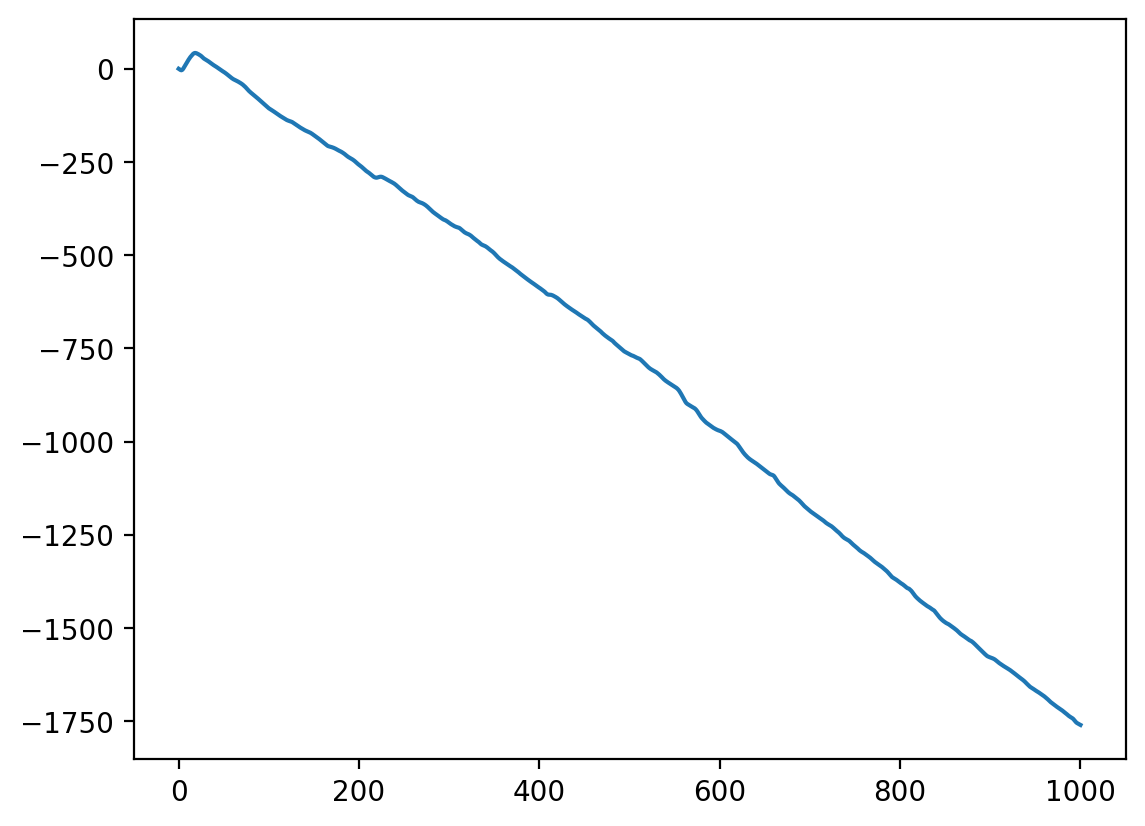

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.plot(np.cumsum(rewards))
plt.show()


In [12]:
len(qs[0])

74

In [13]:
def plot_kinematics(qs, up_to, idx=-1, total_len=2000):
    fig = plt.figure(figsize=(5, 5))
    if idx == -1:
        qs = [r.q for r in rollout[:up_to]]
        for _idx in range(len(qs[0])):
            plt.scatter(up_to, qs[up_to-1][_idx], c="r")
    else:
        # qs = [r.subtree_com[1][idx] for r in rollout[:up_to]]
        qs = [r.q[idx] for r in rollout[:up_to]]
        plt.scatter(up_to, qs[up_to-1], c="r")
        
    _ = plt.plot(qs, alpha=0.8)
    plt.xlim(0, total_len)
    plt.ylim(-0.15, 0.15)
    plt.axvline(x=up_to, c="r")
    
    plt.title(f"r.q[{idx}] Trajectory")
    fig.canvas.draw()
    graph = np.array(PIL.Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb()))
    graph = cv2.resize(graph, dsize=(500, 500), interpolation=cv2.INTER_CUBIC)
    return graph


def stack_vids(vids, qs, up_to=500, target_idx=2):
    concat_vids = []
    for idx, frame in tqdm(enumerate(vids[:up_to])):
        plot = plot_kinematics(qs, idx+1, idx=target_idx, total_len=up_to)
        total = np.hstack((frame, plot))
        concat_vids.append(total)
    return concat_vids

In [14]:
import matplotlib
matplotlib.use('svg') 

In [15]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.

videos = stack_vids(video, qs, target_idx=2)

0it [00:00, ?it/s]

500it [00:14, 34.88it/s]


In [16]:
media.show_video(videos, fps=30)

In [17]:
graph.shape

NameError: name 'graph' is not defined

In [ ]:
which = 2
front = 200
qs = [r.q[which] for r in rollout[:front]]
_ = plt.plot(qs, alpha=0.8)
plt.xlim(0, 2000)
plt.axvline(x=front, c="r")
plt.scatter(front, qs[front-1], c="r")
plt.title(f"r.q[{which}] Trajectory")